# Multilayer Perceptron
## Implemented from scratch using numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections.abc
import pdb

### Some activation functions

In [9]:
def softplus(z):
    return np.log(1+np.exp(z))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

# requires outputs and ground truth
def der_softmax(x, gt):
    return x-gt
    
def relu(x):
    return np.where(x > 0, x, 0)

def der_relu(x):
    return np.where(x > 0, 1, 0)

def fermi(x):
    return 1 / (1 + np.exp(-x))

def der_fermi(x):
    return fermi(x)*(1-fermi(x))

def linear(x):
    return x

def der_linear(x):
    return 1

### Network class

In [3]:
class Network:

    def __init__(self, input_neurons, hidden_neurons, output_neurons, activation, derivative, act_out, der_out, classification):
        layers = []
        biases = []
        for i in range(len(hidden_neurons)):
            if i == 0:
                if input_neurons == 1:
                    layers.append(np.random.rand(hidden_neurons[i])*2-1)

                else:
                    layers.append(np.random.rand(input_neurons, hidden_neurons[i])*2-1)
            else:
                layers.append(np.random.rand(hidden_neurons[i-1], hidden_neurons[i])*2-1)
            biases.append(np.random.rand(hidden_neurons[i])*2-1)

        layers.append(np.random.rand(hidden_neurons[-1], output_neurons)*2-1)
        biases.append(np.random.rand(output_neurons))
        self.create_network(layers, biases, activation, derivative, act_out, der_out, classification)

    def create_network(self, layers, bias, activation_hidden, derivative_hidden, activation_out, derivative_out, classification):
        self.input = None
        self.output = None
        self.ground_truth = None
        self.classification = classification
        self.layers = layers
        self.bias = bias
        self.outs = []
        self.deltas = []
        self.diffs = []
        self.diffs_bias = []
        self.nets = []
        self.act = activation_hidden
        self.der = derivative_hidden
        self.act_out = activation_out
        self.der_out = derivative_out
        self.errors = []

    def update_weights(self):
        for index, layer in enumerate(self.layers):
            self.layers[index] = self.layers[index] + np.array(self.diffs[-1-index], dtype=object).reshape(layer.shape)  
        for index, (bias, diff) in enumerate(zip(self.bias, np.flip(self.diffs_bias, 0))):
            self.bias[index] = self.bias[index] + np.array(diff, dtype=object).reshape(bias.shape)        
            
    # loss for regression
    def reg_loss(self, y_hat, y):
        return y_hat - y
        
    # cross entropy for classification
    def cross_entropy(self, y_hat, y):
        return np.sum(np.where(y_hat == 1, -np.log(y), 0))
        
        
    def forward(self, x, ground_truth):
        self.outs = []
        self.input = x
        self.ground_truth = ground_truth
        output_last_layer = x
        if np.isscalar(x):
            self.outs.append([x])
        else:
            self.outs.append(x)
        self.nets = []
        # Calculate and save outputs from hidden layers
        for index, (layer, bias) in enumerate(zip(self.layers, self.bias)):
            net_h = np.dot(output_last_layer, layer) + bias
            self.nets.append(net_h)
            out = (np.dot(output_last_layer, layer) + bias)
            output = self.act((out).astype(float))
            self.outs.append(output.flatten())
            output_last_layer = self.act_out(output)
        self.output = output_last_layer
        return self.output
   
    def backward(self):
        # Get relevant values for backprop from class attributes
        y_hat = self.ground_truth
        y = self.output
        lr = self.lr
        self.diffs = []
        self.diffs_bias = []
        self.deltas = []
        # Calculate delta for output neuron(s);
        if self.classification:
            delta_m = -self.loss(y_hat, y) * self.der_out(y.astype(float), y_hat)
        else:
            delta_m = self.loss(y_hat, y) * self.der_out(self.nets[-1].astype(float))
        # Apply delta rule to output layer
        self.deltas.append(delta_m)
        self.diffs.append(lr * np.outer(self.outs[-2], delta_m))
        self.diffs_bias.append(lr * delta_m)
        # Apply delta rule to hidden layers
        for index in range(len(self.layers[:-1])):
            delta_h = []
            diffs_layer = []
            diffs_bias = []
            # Calculate deltas from next layer
            for n, neuron in enumerate(self.layers[-index-1]):
                net_n = self.nets[-index-2].flatten()[n]
                delta_h.append(np.dot(self.deltas[-1], neuron) * self.der(net_n))
            self.deltas.append(delta_h)
            for n, neuron in enumerate(self.layers[-index-2]):
                diffs = []
                if len(self.layers[-index-2].shape) > 1:
                    for w, weight in enumerate(neuron):
                        diffs.append(np.dot(np.dot(lr, delta_h[w].item()), (self.outs[-index-3][n])))
                else:
                    diffs = np.dot(np.dot(lr, delta_h[n]), self.outs[-index-3])
                diffs_layer.append(diffs)
            self.diffs_bias.append(np.dot(lr, delta_h))
            self.diffs.append(diffs_layer)
            
            
    def train(self, lr, epochs, error_epochs, inputs, gt):
        self.lr = lr
        if not self.classification:
            self.loss = self.reg_loss
        else:
            self.loss = self.cross_entropy
        indices = np.arange(len(inputs))
        for epoch in range(epochs):
            if epoch % 10 == 0:
                print("Epoch: " + str(epoch))
            np.random.shuffle(indices)
            for index in indices:
                output = self.forward(inputs[index], gt[index])
                self.backward()
                self.update_weights()
            if epoch % error_epochs == 0:
                outputs = [self.forward(x, y) for (x,y) in zip(inputs, gt)]
                error = np.array([self.loss(y_hat, y) for (y, y_hat) in zip(outputs, gt)], dtype=object)
                self.errors.append(np.mean(error))

### Function to instantiate network

In [4]:
def create_network(input_neurons, hidden_neurons, output_neurons, activation, derivative, act_out, der_out, classification):
    layers = []
    biases = []
    for i in range(len(hidden_neurons)):
        if i == 0:
            if input_neurons == 1:
                layers.append(np.random.rand(hidden_neurons[i])*2-1)

            else:
                layers.append(np.random.rand(input_neurons, hidden_neurons[i])*2-1)
        else:
            layers.append(np.random.rand(hidden_neurons[i-1], hidden_neurons[i])*2-1)
        biases.append(np.random.rand(hidden_neurons[i])*2-1)

    layers.append(np.random.rand(hidden_neurons[-1], output_neurons)*2-1)
    biases.append(np.random.rand(output_neurons))
    #net = Network(np.array(layers, dtype=object), biases, activation, derivative)
    net = Network(layers, biases, activation, derivative, act_out, der_out, classification)
    return net

## Example for regression on a random quadratic function

In [5]:
def f(x):
    return 0.2*x**2 - 0.5*x + 1.0

In [6]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,10))

data_x = np.linspace(-500, 500, 1000)
data_y = f(data_x)
# normalize data
transformed_data = min_max_scaler.fit_transform(np.array([data_x, data_y]).transpose())

data_x = transformed_data[:,0]
data_y = transformed_data[:,1]

train_indices = np.sort(np.random.choice(1000, replace=False, size=800))
test_indices = np.sort(np.array([x for x in range(1000) if x not in train_indices]))
x_train = data_x[train_indices]
y_train = data_y[train_indices]

x_test = data_x[test_indices]
y_test = data_y[test_indices]

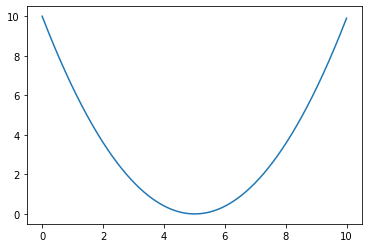

In [7]:
plt.plot(data_x, data_y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [44]:
lr = 0.001
epochs = 100
error_epochs = 1

#network = Network(1, [2], 1, softplus, fermi, linear, der_linear, classification=False)
network = Network(1, [16], 1, relu, der_relu, linear, der_linear, classification=False)
network.train(lr, epochs, error_epochs, x_train, y_train)

Epoch: 0


C:\Users\simon\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


Training Error


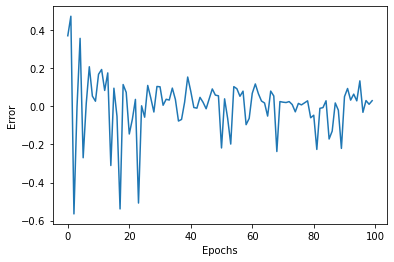

Output


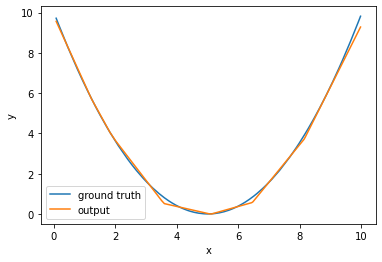

In [45]:
net_output = [network.forward(x, y) for (x,y) in zip(x_test, y_test)]

print("Training Error")
plt.plot(np.arange(len(network.errors)), network.errors)
plt.xlabel("Time")
plt.ylabel("Error")
plt.show()

print("Output")
plt.plot(x_test, y_test, label='ground truth')
plt.plot(x_test, net_output, label='output')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Example for classification using iris flower dataset

In [46]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

lb = preprocessing.LabelBinarizer()

# import data
iris = datasets.load_iris()

# 150 samples with 4 features and 3 total categories
X = iris.data
y = iris.target
# transform labels into label vectors for neural network
y = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [69]:
lr = 0.005
epochs = 100
error_epochs = 10

np.seterr('raise')

network = Network(4, [16], 3, softplus, fermi, softmax, der_softmax, classification=True)
#network = Network(4, [8], 3, relu, der_relu, softmax, der_softmax, classification=True)
network.train(lr, epochs, error_epochs, X_train, y_train)

Epoch: 0


C:\Users\simon\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


Accuracy: 0.94


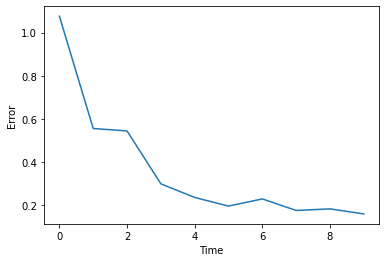

In [70]:
net_output = [network.forward(x, y) for (x,y) in zip(X_test, y_test)]

net_output = np.argmax(net_output, axis=1)
y_labels = np.argmax(y_test, axis=1)

correct = net_output == y_labels
accuracy = np.sum(correct) / len(y_labels)
print("Accuracy: " + str(accuracy))

plt.plot(np.arange(len(network.errors)), network.errors)
plt.xlabel("Time")
plt.ylabel("Error")
plt.show()